# CSII 2024 Exercise 11: Nonlinear Control Part 1
&copy; 2024 ETH Zurich, Felix Schnitzler, Jungcheng Fu, Dejan Milojevic, Paolo Petri, Joël Gmür; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

## Description
This week's Jupyter notebook will cover feedback linearization and differential flatness.


As usual, we start by installing the `control` module and import the required libraries.

In [133]:
# Install the required python library with pip 
%pip install control

Note: you may need to restart the kernel to use updated packages.


In [134]:
import numpy as np
import control as ct
import control.flatsys as fs
import matplotlib.pyplot as plt

## Problem 1
You are an engineer on a racing team for Formula 1 and you are currently working on optimizing the drag force on your teams racecar. To model the vehicles behaviour you need to recall the equation for Drag force that you first learned about at ETH.
$$ F_{d} = \frac{1}{2}\rho c_d A\dot{x}(t)^2 , $$ 
where $\rho$ is the density of air, $c_d$ is the drag coefficient and $A$ is the affected reference area.
We model the total force $F_{tot}$ on the vehicle as the combination of the input acceleration $u(t)$ and the drag force $F_d$:
$$ F_{tot} = m u(t) - F_d$$
Writing this in familiar notation we get:
$$ m\ddot{x}(t) = -\frac{1}{2}\rho c_d A\dot{x}(t)^2 + mu(t)$$
Since we are interested in the velocity of the system, we can transform this into a first order differential equation by setting $v(t) = \dot{x}(t)$. The total system now reads:
\begin{align*}
\dot{v}(t) &= -\gamma v(t)^2 + u(t)\\
y(t) &= v(t)
\end{align*}
where $\gamma = \frac{1}{2m}\rho c_d A$ and $y(t)$ is the output of the system.


### Exercise 1.1

Define the nonlinear system in the function 'nonlinear_system' below. The function should take the state $x$, the input $u$ and the parameters $\gamma$ as arguments and return the derivative of the state $vdot$ as well as the output $y$.

You can use the following information to evaluate $\gamma$:

$m = 800kg$, $\rho = 1.293 \frac{kg}{m^3}$, $c_d = 1.1$, $A = 1.38$

In [174]:
gamma = 1.293 * 1.1 * 1.38 * 1 / (2 * 800)
print(gamma)

def nonlinear_sys(t, v, u, params=(gamma)):
  vdot = -gamma*v**2 + u
  return vdot

def nonlinear_sys_out(t, v, u, params=(None)):
  y = v
  return y

0.00122673375


### Exercise 1.2

Using the control library, define the input-output system `sys` and simulate the response of the system.
Hint: You can use the function `ct.NonlinearIOSystem()` to define `sys`.

We will analyse the cars behaviour in response to an input acceleration of $20 \frac{m}{s^2}$ or approximately 2G's.

In [175]:
sys = ct.NonlinearIOSystem(nonlinear_sys, nonlinear_sys_out)

t = np.linspace(0, 30, 1000)
u = 20

t_out, y_out = ct.input_output_response(sys, T=t, U=u, X0=[0])

The next block plots the reaction of the car due to the acceleration input $u$. Note that there seems to be a point where the car does not accelerate anymore. This is the speed where the drag force becomes so strong that the car remains at a equilibrium velocity. This operation point is called stagnation speed.

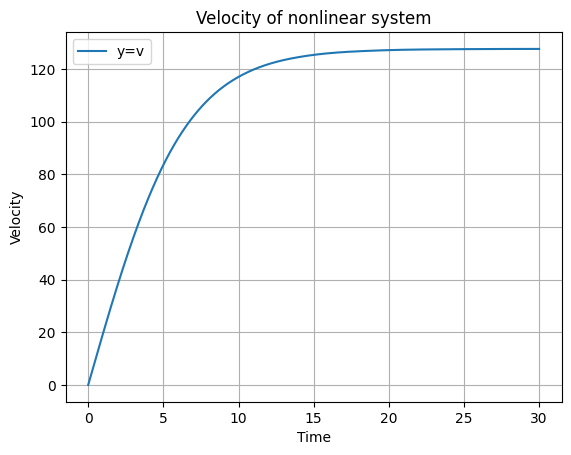

In [137]:
# Plot the response
plt.plot(t_out, y_out[0], label='y=v')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Velocity of nonlinear system')
plt.legend()
plt.grid(True)
plt.show()


### Exercise 1.3

At high speeds, the car can have strong reactions to external disturbances such as wind gusts. To calculate parameters for the car's design more easily, you decide to linearize the model. Evaluate the equilibrium point around which we will linearize the system. Assume that we are still accelerating with $u = 20\frac{m}{s^2}$.

_Hint: The system function is symmetrical, thus, when the initial state $x_0 = 0$, it may take the negative solution. Set a slight positive number to get a positive solution_.


In [154]:
v_eq,u_eq,y_eq = ct.find_eqpt(sys, [0.01], [20], return_y=True)

print("Input acceleration u_eq =", u_eq[0], "m/s^2")
print("Stagnation speed y_eq =", y_eq[0],"m/s")

Input acceleration u_eq = 20 m/s^2
Stagnation speed y_eq = 127.68498827514793 m/s


### Exercise 1.4

Linearize the system around the evaluated equilibrium point $(u_{eq}, y_{eq})$. The system can now be written as a state-space model:

\begin{align*}
\dot{v}(t) &= Av(t) + u(t)\\
y(t) &= v(t) 
\end{align*}

Additionally, print the system's A matrix.


In [139]:
linearized_sys = ct.linearize(sys,[v_eq],[u_eq])

A_matrix = linearized_sys.A

print(A_matrix)

[[-0.31327097]]


### Exercise 1.5 REWORK

Now we have our linearized system, we want to use this system model to calculate the compensation acceleration of a sudden increase in wind speed.

The linearized system simply takes the slope of the nonlinear function at that given speed point and doesn't have an offset. So the calculation with the linearized system must add an offset to it, hence we must subtract the equilibrium point.

In [179]:
# Wind speed increases to 128 m/s
v_current = 135
u_current = 20

# Prepare for linearized system calculation
delta_v = v_current - v_eq

# Solve the equation for the compensation 
# acceleration to maintain the same ground speed
delta_u = -A_matrix*delta_v

print("Linear model based wind speed = ", v_eq[0], "m/s")
print("Current wind speed = ", v_current, "m/s")
print("(Speed difference) = ", delta_v[0], "m/s")
print("Compensation Acc. = ", delta_u[0,0], "m/s²")

Linear model based wind speed =  127.68498827514793 m/s
Current wind speed =  135 m/s
(Speed difference) =  7.31501172485207 m/s
Compensation Acc. =  2.291580818998862 m/s²


Now we simulate the system to validate if the calculation is correct.

Hint, pay attention to the unit or magnitude of the plot!

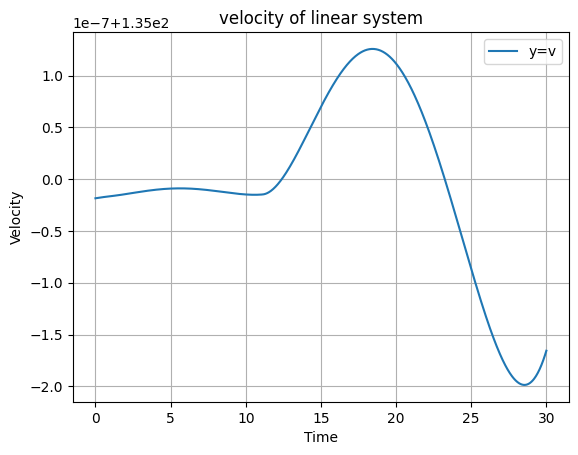

t= 30.0 s speed= 134.9999998343452 m/s


In [182]:
# Simulate the system to validate if the calculation is correct.
t = np.linspace(0, 30, 1000)
delta_u = np.ones_like(t) * delta_u
t_out, delta_y_out = ct.input_output_response(linearized_sys, T=t, U=delta_u, X0=[delta_v])

y_out = y_eq + delta_y_out

# Plot the response
plt.plot(t_out, y_out, label='y=v') 
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('velocity of linear system')
plt.legend()
plt.grid(True)
plt.show()

print('t=',t_out[999],"s",'speed=',y_out[999],"m/s")

We observed the linearized system response with the compensation acceleration to the current wind gust can very well maintain the car at a constant ground speed.

Now we validate this through plugging in the same data into the nonlinear system.

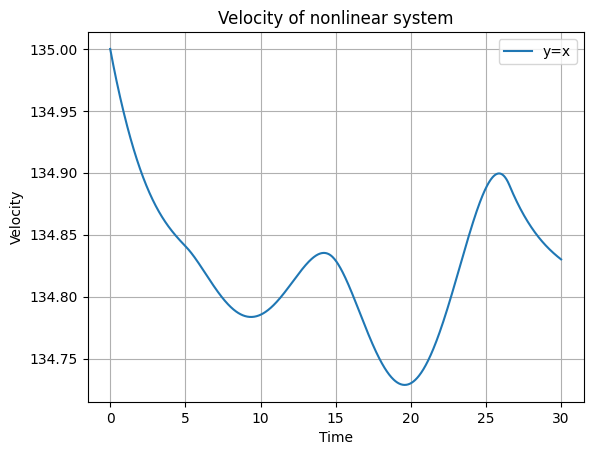

t= 30.0 s speed= 134.83005974310578 m/s


In [181]:
# Validation using the original system

t_out, y_out = ct.input_output_response(sys, T=t, U=(u+delta_u), X0=[v_current])

# Plot the response
plt.plot(t_out, y_out[0], label='y=x') 
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title('Velocity of nonlinear system')
plt.legend()
plt.grid(True)
plt.show()

print('t=',t_out[999],"s",'speed=',y_out[0,999],"m/s")

we noticed that the linearized system gives a very similar response compared with the nonlinear one.
Conclusion:
Using this, we can linearize a nonlinear function around any point and make a LTI system with matrixes A,B,C,D to apply our familiar control theories.

## Problem 2: Feedback linearization

In the last exercise we saw that a linear approximation of a system works well close to an equilibrium point. If the system moves to far away from this operation point, the linearization does not reflect the real behaviour anymore and a feedback system could become unstable.

In this exercise we will look at feedback linearization, which is a different approach to controlling a nonlinear system.

Assume that we have the same system equation as in exercise 01 but with an added term $F_f$ that models varying friction due to impurities of the road.

$$ F_{tot} = m u(t) - F_d - F_f $$

Rewriting this with $F_f = \mu m g sin(x(t))$ we get:

$$ m\ddot{x}(t) = -\frac{1}{2}\rho c_d A\dot{x}(t)^2 - \mu m g sin(x(t)) + mu(t)$$